In [1]:
# main.py
import numpy as np
import gym
#from DDPG_trial import DDPG
from collections import deque
import pdb
import torch
from env import env
from LSTM import LSTMModel  
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

import pdb 
M, N, J = 10, 4, 3
# Replay Buffer for Experience Replay
class ReplayBuffer:
    def __init__(self, max_size=int(1e6)):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, next_state, action, reward):
        self.buffer.append((state, next_state, action, reward))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, next_state, action, reward = map(np.stack, zip(*batch))
        return (
            torch.FloatTensor(state),
            torch.FloatTensor(next_state),
            torch.FloatTensor(action),
            torch.FloatTensor(reward).unsqueeze(1),
            #torch.FloatTensor(done).unsqueeze(1),
        )

    def size(self):
        return len(self.buffer)

###########generate random discrete matrix for actions(should ideally come from the discretization procedure)


def generate_matrix(N, J):
    # Initialize an NxJ matrix filled with zeros
    matrix = np.zeros((N, J), dtype=int)
    
    # Ensure each column has at least one 1
    for j in range(J):
        # Randomly select a row to place the 1 in column j
        while True:
            row_index = np.random.randint(N)
            # Place the 1 only if that row currently contains no 1
            if np.sum(matrix[row_index]) == 0:
                matrix[row_index, j] = 1
                break
    
    # Fill remaining rows with either a single 1 or all 0s
    for i in range(N):
        if np.sum(matrix[i]) == 0:  # If the row is all zeros
            if np.random.rand() > 0.5:  # 50% chance to add a 1
                col_index = np.random.randint(J)
                matrix[i, col_index] = 1
    
    return matrix


In [2]:
#model = torch.load('LSTM.pth')
# Initialize the model architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model parameters
input_dim = N
hidden_dim = 128
output_dim = N
num_layers = 1

# Initialize the model, loss function and optimizer
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers).to(device)
#model = LSTMModel()  # Initialize your model with the required parameters

# Load the saved state dictionary
model.load_state_dict(torch.load('LSTM_state_dict.pth'))


C:\Users\sriniva3\AppData\Local\Temp\ipykernel_10412\2664193153.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('LSTM_state_dict.pth'))

<All keys matched successfully>

In [3]:
Ts = 10000
environ = env(Ts = Ts, N = N, M = M, J= J )
alltime_fast_fading_gains = environ.fast_fading_channel_coefficients()
TxRxds = environ.compute_TxRX()
alltime_PathGains = environ.large_scale_fading_channel_coefficients(TxRxds)

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:02<00:00, 3836.16it/s]


In [4]:
def get_lstm_pred_SINR(ts_start, ts_end):
    history = 10
    SINR_nxt_lstm = np.zeros((J,N))
    for j in range(J):
        inp = []
        for ts in np.arange(ts_start, ts_end):
            SINR =  environ.get_next_state(alltime_PathGains, alltime_fast_fading_gains, ts = ts)[0]
            inp.append(SINR[:,j])
        inp = np.array(inp).reshape(1,history,N)
        SINR_nxt_lstm[j,:] = model(torch.Tensor(inp)).detach().numpy()[0]
    SINR_nxt_lstm = np.transpose(SINR_nxt_lstm)
    return SINR_nxt_lstm


In [5]:
'''
b_prev_actions =  generate_matrix(N, J)
state_lstm = get_lstm_pred_SINR(ts_start = 0, ts_end = 10)
state = np.stack((np.multiply(state_lstm, b_prev_actions),b_prev_actions), axis = 0)
b_prsnt_actions =  generate_matrix(N, J)
nxt_state_lstm = get_lstm_pred_SINR(ts_start = 1, ts_end = 11)
next_state = np.stack((np.multiply(nxt_state_lstm, b_prsnt_actions),b_prsnt_actions), axis = 0)
'''

'\nb_prev_actions =  generate_matrix(N, J)\nstate_lstm = get_lstm_pred_SINR(ts_start = 0, ts_end = 10)\nstate = np.stack((np.multiply(state_lstm, b_prev_actions),b_prev_actions), axis = 0)\nb_prsnt_actions =  generate_matrix(N, J)\nnxt_state_lstm = get_lstm_pred_SINR(ts_start = 1, ts_end = 11)\nnext_state = np.stack((np.multiply(nxt_state_lstm, b_prsnt_actions),b_prsnt_actions), axis = 0)\n'

In [6]:
# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x * self.max_action

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        #pdb.set_trace()
        return q_value

In [7]:
# DDPG Agent
class DDPG:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(torch.device("cpu"))
        self.actor_target = Actor(state_dim, action_dim, max_action).to(torch.device("cpu"))
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)

        self.critic = Critic(state_dim, action_dim).to(torch.device("cpu"))
        self.critic_target = Critic(state_dim, action_dim).to(torch.device("cpu"))
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.max_action = max_action
        self.discount = 0.99
        self.tau = 0.005

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(torch.device("cpu"))
        action = self.actor(state).cpu().data.numpy().flatten()
        return action

    def train(self, replay_buffer, t, batch_size=64):
        # Sample a batch of transitions from the replay buffer
        state, next_state, action, reward = replay_buffer.sample(batch_size)
        next_state = next_state.view(batch_size,-1)
        state = state.view(batch_size,-1)
        action = action.view(batch_size,-1)
        # Compute the target Q value
        #pdb.set_trace()
        next_action = self.actor_target(next_state)
        target_q = self.critic_target(next_state, next_action)
        #target_q1, target_q2 = self.critic_target(next_state, next_action)
        #target_q = torch.min(target_q1, target_q2)
        if t < 256:
            not_done = 1.0
        else:
            not_done = 0.0
        #pdb.set_trace()
        target_q = reward + not_done * self.discount * target_q.detach()

        # Get current Q estimate
        current_q = self.critic(state, action)
        #current_q1, current_q2 = self.critic(state, action)
        #current_q = torch.min(current_q1, current_q2)
        # Compute critic loss
        critic_loss = F.mse_loss(current_q, target_q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Compute actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()

        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update the target networks
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

In [8]:
T = 256
############# get initial states  #############
'''
b_prev_actions =  generate_matrix(N, J)
state_lstm = get_lstm_pred_SINR(ts_start = 0, ts_end = 10)
state = np.stack((np.multiply(state_lstm, b_prev_actions),b_prev_actions), axis = 0)
b_prsnt_actions =  generate_matrix(N, J)
nxt_state_lstm = get_lstm_pred_SINR(ts_start = 1, ts_end = 11)
next_state = np.stack((np.multiply(nxt_state_lstm, b_prsnt_actions),b_prsnt_actions), axis = 0)
'''
############################################################
state_dim = 2*N*J
action_dim = N*J
max_action = 1.0
time_slots = np.arange(0,Ts)

agent = DDPG(state_dim, action_dim, max_action)
agent2 = DDPG(state_dim, action_dim, max_action)

replay_buffer = ReplayBuffer()
replay_buffer2 = ReplayBuffer()

#train_agents(env, agent1, agent2, replay_buffer)
episodes=50
batch_size=128

ts_counter = 0

######## generate interactions dummy ###########
interfers_actions = np.zeros((M-1, J, N)) # should be the actions from other agent. 
for i, m in enumerate(range(M-1)):
    interfers_actions[i,:,:] = np.transpose(generate_matrix(N, J))

In [9]:
epi_rewards = []
epi_rewards2 = []
b_prev_actions =  generate_matrix(N, J)
P_e = []
P_e2 = []
for episode in range(episodes):
        ############# get initial states  #############
        if episode == 0:
            state_lstm = get_lstm_pred_SINR(ts_start = 0, ts_end = 10)
        else:
            state_lstm = get_lstm_pred_SINR(ts_start = ts_counter, ts_end = ts_counter+10)
        #state = np.stack((np.multiply(state_lstm, b_prev_actions),b_prev_actions), axis = 0)
        state = np.stack((state_lstm,b_prev_actions), axis = 0)
        state2 = np.stack((state_lstm,b_prev_actions), axis = 0)
        #b_prsnt_actions =  generate_matrix(N, J)
        #nxt_state_lstm = get_lstm_pred_SINR(ts_start = 1, ts_end = 11)
        #next_state = np.stack((np.multiply(nxt_state_lstm, b_prsnt_actions),b_prsnt_actions), axis = 0)
        ############################################################
        episode_reward = 0
        episode_reward2 = 0
        for t in range(T):
            action = agent.select_action(np.array(state))
            action2 = agent2.select_action(np.array(state2))
            #action =  (action >= 0.5).astype(float)
            #next_state, reward, done, _ = env.step(action)
            nxt_state_lstm = get_lstm_pred_SINR(ts_start = ts_counter+1, ts_end = ts_counter + 11)
            #next_state = np.stack((np.multiply(nxt_state_lstm, action.reshape(N,J)),action.reshape(N,J)), axis = 0)
            next_state = np.stack((nxt_state_lstm,action.reshape(N,J)), axis = 0)
            next_state2 = np.stack((nxt_state_lstm,action.reshape(N,J)), axis = 0)
            
            state = next_state
            state2 = next_state2
            #reward = np.sum(environ.compute_rewards(alltime_PathGains, alltime_fast_fading_gains, ts = time_slots[ts_counter + 10],
                                                    #b = 0, interfers_actions = interfers_actions, b_actions = b_prev_actions)[2])
            _, p_e, reward = environ.compute_rewards(alltime_PathGains, alltime_fast_fading_gains, ts = time_slots[ts_counter + 10],
                                                    b = 0, interfers_actions = interfers_actions, b_actions = b_prev_actions)
            _, p_e2, reward2 = environ.compute_rewards(alltime_PathGains, alltime_fast_fading_gains, ts = time_slots[ts_counter + 10],
                                                    b = 1, interfers_actions = interfers_actions, b_actions = b_prev_actions)
            
            P_e.append(p_e)
            P_e2.append(p_e2)
            
            reward = np.sum(reward)
            reward2 = np.sum(reward2)
            
            #print(t, p_e, reward)
            episode_reward += reward
            episode_reward2 += reward2
            
            replay_buffer.add(state, next_state, action.reshape(N,J), reward)
            replay_buffer2.add(state2, next_state2, action2.reshape(N,J), reward2)

            if replay_buffer.size() > batch_size:
                agent.train(replay_buffer, t, batch_size)
            if replay_buffer2.size() > batch_size:
                agent2.train(replay_buffer2, t, batch_size)
            ts_counter+=1
            if ts_counter == Ts - 10:
                ts_counter = 0
            #print(ts_counter)
        b_prev_actions = action.reshape(N,J)
        b_prev_actions2 = action2.reshape(N,J)
        
        print(f"Episode: {episode + 1}, Reward: {episode_reward/256}")
        print(f"Episode: {episode + 1}, Reward: {episode_reward2/256}")
        
        epi_rewards.append(episode_reward/256)
        epi_rewards2.append(episode_reward2/256)

Episode: 1, Reward: 6.657832628455567
Episode: 1, Reward: 6.657832628455567
Episode: 2, Reward: -0.42616370954412297
Episode: 2, Reward: -1.4906249203306619
Episode: 3, Reward: 13.767905249222425
Episode: 3, Reward: 12.621500248681018
Episode: 4, Reward: 12.344340966694556
Episode: 4, Reward: 11.305045552604193
Episode: 5, Reward: 5.889715258485854
Episode: 5, Reward: 5.563052577626876
Episode: 6, Reward: 7.657091504958506
Episode: 6, Reward: 4.981144790972671
Episode: 7, Reward: -0.27863066594220837
Episode: 7, Reward: -1.7480382650221222
Episode: 8, Reward: 13.512509537194365
Episode: 8, Reward: 12.344076989896708
Episode: 9, Reward: 13.174291321960398
Episode: 9, Reward: 12.199478180678097
Episode: 10, Reward: 14.20493293655833
Episode: 10, Reward: 13.12070767856016
Episode: 11, Reward: 13.023686921380257
Episode: 11, Reward: 12.391950428071658
Episode: 12, Reward: 13.554865448417976
Episode: 12, Reward: 11.732129785499103
Episode: 13, Reward: 10.27455729564162
Episode: 13, Reward: 

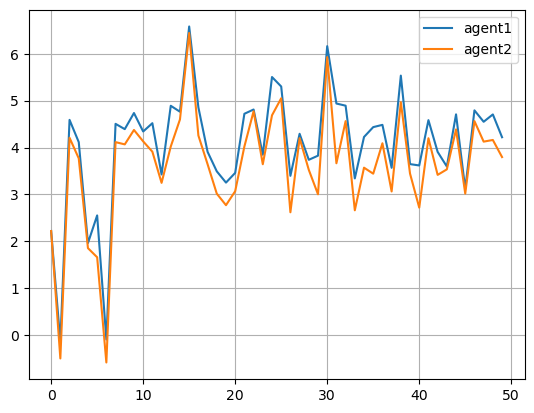

In [10]:
plt.plot(np.array(epi_rewards)/J, label = 'agent1')
plt.plot(np.array(epi_rewards2)/J, label = 'agent2')
plt.legend()
plt.grid()

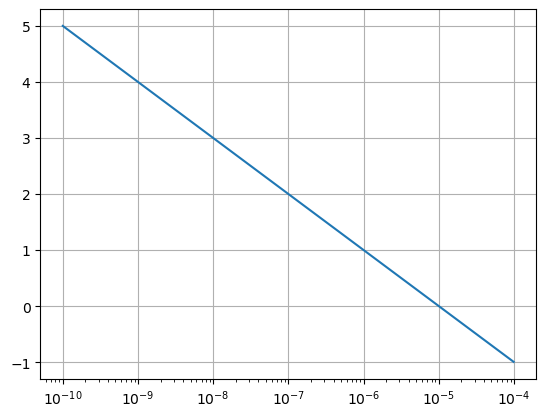

In [11]:
P_o = 1e-5
P_e = np.arange(1e-10,1e-4,1e-6)
reward = -np.log10(P_e/P_o)
plt.semilogx(P_e, reward)
plt.grid()

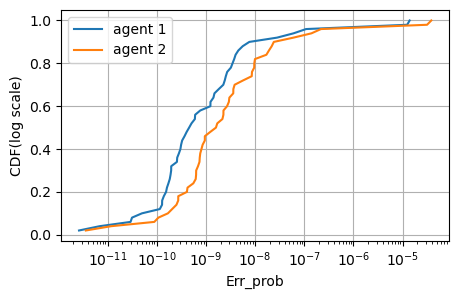

In [12]:
p_o =  1e-5
#rewards = np.array(epi_rewards)/J
err_prob = p_o*(np.power(10,-np.array(epi_rewards)/J))
err_prob2 = p_o*(np.power(10,-np.array(epi_rewards2)/J))

def return_cdf(a):
    sorted_a = np.sort(a)
    cdf = np.arange(1, len(sorted_a) + 1) / len(sorted_a)
    return sorted_a, cdf

a, cdf = return_cdf(err_prob)
a2, cdf2 = return_cdf(err_prob2)
plt.figure(figsize= [5,3])
#plt.ylim(np.min(cdf2))
plt.semilogx(a, cdf, label = r'agent 1')
plt.semilogx(a2, cdf2, label = r'agent 2')
plt.grid()
plt.xlabel('Err_prob')
plt.ylabel('CDF(log scale)')
plt.legend()